# 🏠 Housing Prices 🏠
## 5 - 6. Final Model Selection and Submission

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import dtreeviz
import optuna

pd.options.display.max_rows = 40
pd.options.display.max_columns = 40


In [2]:
df = pd.read_csv('../input/home-data-for-ml-course/train.csv')
dft = pd.read_csv('../input/home-data-for-ml-course/test.csv')

columns = df.columns.tolist()

nan_row = {col: np.nan for col in columns}

# Convert to DataFrame
df_nan = pd.DataFrame([nan_row])

df = pd.concat([df,df_nan]).reset_index(drop=True)
df = df.drop(columns=['Id'])
df.loc[df.YrSold.isna(),'YrSold'] = 2008.

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

cond = (df.YrSold<2010)

train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log


In [3]:
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
to.items = to.items.drop(index=1460)

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [4]:
xs, y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs,to.valid.y

full_xs, full_y = to.xs, to.y

In [5]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

def rmse_2(pred,y):
    return np.sqrt(mean_squared_error(y,pred))

## Create Elastic Net Model

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


# Define the model
model = ElasticNet()

# Hyperparameter grid to search 
param_grid = {
    'alpha': [0.001,0.002,.003,.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,100],
    'l1_ratio': [0.001,0.002,.003,.005,0.01,0.02,0.05,0.1,0.2,0.5,0.9,0.99]
} 

# Create a GridSearchCV 
grid_search = GridSearchCV(estimator=model, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring='neg_root_mean_squared_error') 

rmses = [1,4,5,6]
best_rmses = min(rmses)
#ML likes to maximize compared to minimize
neg_rmses = [-1,-4,-5,-6]
best_neg_rmses = max(neg_rmses)

# Fit the grid search to the training data
grid_search.fit(xs, y) 

# Get the best parameters 
best_params_en = grid_search.best_params_ 
print("Best parameters:", best_params_en) 

# Create a new model with the best parameters 
best_model = ElasticNet(**best_params_en) 
best_model.fit(xs, y) 

# Make predictions on the test set
y_pred_lr = best_model.predict(valid_xs) 

# Evaluate the model (RMSE)
print("RMSE on test set:", math.sqrt(mean_squared_error(valid_y, y_pred_lr)))

final_model_elasticnet = ElasticNet(**best_params_en)
final_model_elasticnet.fit(full_xs,full_y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+00, tolerance: 1.647e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.091e+00, tolerance: 1.556e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.245e+00, tolerance: 1.617e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

Best parameters: {'alpha': 0.002, 'l1_ratio': 0.05}
RMSE on test set: 0.136781432904894


ElasticNet(alpha=0.002, l1_ratio=0.05)

## Create a Random Forest Model

In [7]:
model = RandomForestRegressor()
model.fit(xs, y)
y_pred = model.predict(valid_xs)
m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y), r2_score(valid_y, model.predict(valid_xs)), rmse_2(y_pred,valid_y)

(0.055081, 0.129811, 0.8981562916258119, 0.12981057819428551)

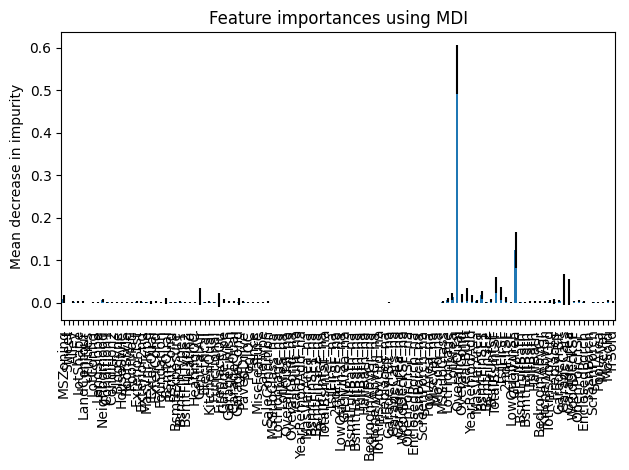

In [8]:
importances = model.feature_importances_
feature_names = xs.columns
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [9]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, valid_xs, valid_y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 10.320 seconds


In [10]:
sorted_importances = forest_importances.sort_values(ascending=False)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances_std = importances_std[sorted_importances.index]

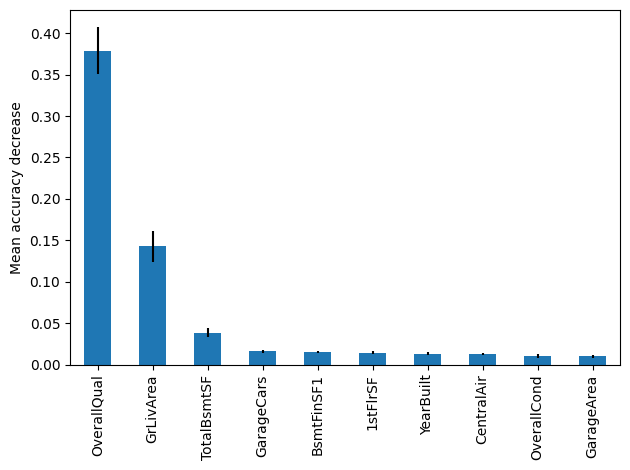

In [11]:
fig, ax = plt.subplots()
keep = 10
sorted_importances[:keep].plot.bar(yerr=sorted_importances_std[:keep], ax=ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [12]:
# Hyperparameter optimization of RandomForestRegressor

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    #n_estimators = trial.suggest_int("n_estimators", 1, 200)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    #max_features = trial.suggest_categorical("max_features", [1])

    # Create and evaluate the model
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
    model.fit(xs, y)
    score = m_rmse(model, valid_xs, valid_y)
    # return np.mean(score)  # Optuna minimizes, so negative MSE
    return score

# Run the optimization
# sampler=optuna.samplers.GPSampler()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters found:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(xs, y)

# Evaluate on test set
test_score = final_model.score(valid_xs, valid_y)
rmse_result = m_rmse(final_model, valid_xs, valid_y)
print("Test RMSE Score:", rmse_result)
print("Test R^2 Score:", test_score)

final_model_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model_rf.fit(full_xs,full_y)

[I 2025-03-13 06:41:36,249] A new study created in memory with name: no-name-5903198a-bcda-4e21-bca4-a32911b8bce7
[I 2025-03-13 06:41:37,838] Trial 0 finished with value: 0.135236 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.135236.
[I 2025-03-13 06:41:40,289] Trial 1 finished with value: 0.129393 and parameters: {'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.129393.
[I 2025-03-13 06:41:41,600] Trial 2 finished with value: 0.142842 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.129393.
[I 2025-03-13 06:41:43,970] Trial 3 finished with value: 0.126942 and parameters: {'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.126942.
[I 2025-03-13 06:41:45,322] Trial 4 finished with value: 0.142611 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf':

Best parameters found: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}
Test RMSE Score: 0.125896
Test R^2 Score: 0.9042056827326237


RandomForestRegressor(max_depth=14, min_samples_leaf=2, n_jobs=-1,
                      random_state=42)

In [13]:
# # Hyperparameter optimization of RandomForestRegressor

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int("n_estimators", 1, 200)
#     # max_depth = trial.suggest_int("max_depth", 3, 30)
#     # min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     # max_features = trial.suggest_categorical("max_features", [1])

#     # Create and evaluate the model
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         # max_depth=max_depth,
#         # min_samples_split=min_samples_split,
#         # min_samples_leaf=min_samples_leaf,
#         # max_features=max_features,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     # Use cross-validation to evaluate the model
#     # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
#     model.fit(xs, y)
#     score = m_rmse(model, valid_xs, valid_y)
#     # return np.mean(score)  # Optuna minimizes, so negative MSE
#     return score

# # Run the optimization
# # sampler=optuna.samplers.GPSampler()
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100, n_jobs=1)

# # Print best parameters
# print("Best parameters found:", study.best_params)

# # Train final model with best parameters
# best_params = study.best_params
# final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
# final_model.fit(xs, y)

# # Evaluate on test set
# test_score = final_model.score(valid_xs, valid_y)
# rmse_result = m_rmse(final_model, valid_xs, valid_y)
# print("Test RMSE Score:", rmse_result)
# print("Test R^2 Score:", test_score)


In [14]:
# # Hyperparameter optimization of RandomForestRegressor

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int("n_estimators", 30, 55)
#     max_depth = trial.suggest_int("max_depth", 3, 30)
#     # min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
#     # max_features = trial.suggest_categorical("max_features", [1])

#     # Create and evaluate the model
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         # min_samples_split=min_samples_split,
#         # min_samples_leaf=min_samples_leaf,
#         # max_features=max_features,
#         random_state=42,
#         n_jobs=-1
#     )
    
#     # Use cross-validation to evaluate the model
#     # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
#     model.fit(xs, y)
#     score = m_rmse(model, valid_xs, valid_y)
#     # return np.mean(score)  # Optuna minimizes, so negative MSE
#     return score

# # Run the optimization
# study = optuna.create_study(sampler=optuna.samplers.GPSampler(), direction="minimize")
# study.optimize(objective, n_trials=100, n_jobs=1)

# # Print best parameters
# print("Best parameters found:", study.best_params)

# # Train final model with best parameters
# best_params = study.best_params
# final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
# final_model.fit(xs, y)

# # Evaluate on test set
# test_score = final_model.score(valid_xs, valid_y)
# rmse_result = m_rmse(final_model, valid_xs, valid_y)
# print("Test RMSE Score:", rmse_result)
# print("Test R^2 Score:", test_score)


## Submission
1. Manual CSV Submission

In [15]:
dft = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
dft_ids = dft[['Id']]
dft= dft.drop(columns=['Id'])
to_tst = to.new(dft)
to_tst.process()
preds_rf = np.exp(final_model_rf.predict(to_tst.xs))
dfpreds_rf = pd.DataFrame(preds_rf)

preds_en = np.exp(final_model_elasticnet.predict(to_tst.xs))
dfpreds_en = pd.DataFrame(preds_en)

df_submit_rf = dft_ids.merge(dfpreds_rf,left_index=True,right_index=True)
df_submit_rf = df_submit_rf.rename(columns = {0:'SalePrice'})

df_submit_en = dft_ids.merge(dfpreds_en,left_index=True,right_index=True)
df_submit_en = df_submit_en.rename(columns = {0:'SalePrice'})

df_submit_rf.to_csv('submission1_rf.csv',index = False)
df_submit_en.to_csv('submission1_en.csv',index = False)

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

## Submission Results
1. Random Forest: Score: 16604.67042 Rank 2245/6946 Top 32%
2. Elastic Net: Score: 15927.00256 Rank 881/6946 Top 13%

## Incorporating External Data

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#mmscaler = StandardScaler()
mmscaler = MinMaxScaler(feature_range = (1,100))
external_data = pd.read_csv('../input/enhancedhousingmarketdata/EnhancedHousingMarketData.csv')
df = pd.read_csv('../input/home-data-for-ml-course/train.csv')
dft = pd.read_csv('../input/home-data-for-ml-course/test.csv')
dep_var = 'SalePrice'
external_data['join_id'] = external_data['Year'].astype(str) + '_' + external_data['Month'].astype(str)
external_data.iloc[:,2:-1] = external_data.iloc[:,2:-1].astype(float)
external_data.iloc[:,2:-1] = mmscaler.fit_transform(external_data.iloc[:,2:-1])
df = df.iloc[:-1]
df['YrSold'] = df['YrSold'].astype(int)
df['MoSold'] = df['MoSold'].astype(int)
df['join_id'] = df['YrSold'].astype(str) + '_' + df['MoSold'].astype(str)
df_total = df.merge(external_data, on = ['join_id']).drop(columns = ['join_id','Year','Month','Id'], axis =1)

<ipython-input-16-09b279de6a4c>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     33469.0
1     33469.0
2     33469.0
3     33469.0
4     33469.0
       ...   
55    34612.0
56    34612.0
57    34612.0
58    34612.0
59    34612.0
Name: AnnualPerCapitaIncome, Length: 60, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
<ipython-input-16-09b279de6a4c>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     45368.0
1     46649.0
2     46289.0
3     47049.0
4     46400.0
       ...   
55    49145.0
56    51897.0
57    52123.0
58    52090.0
59    51550.0
Name: EmployedIndividuals, Length: 60, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


In [17]:
from sklearn.model_selection import train_test_split

columns_ext = df_total.columns.tolist()
nan_row_ext = {col: np.nan for col in columns_ext}
# Convert to DataFrame
df_nan_ext = pd.DataFrame([nan_row_ext])

df_total = pd.concat([df_total,df_nan_ext]).reset_index(drop=True)
dep_var = 'SalePrice'
df_total[dep_var] = np.log(df_total[dep_var])

train,valid = train_test_split(df_total,test_size=0.2, random_state = 42)
train_idx_ext, valid_idx_ext = train.index, valid.index
splits = (list(train_idx_ext),list(valid_idx_ext))

procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df_total, 1, dep_var=dep_var)
to_ext = TabularPandas(df_total, procs, cat, cont, y_names=dep_var, splits=splits)
to_ext.items = to_ext.items.drop(index=1459)
df_total = df_total.iloc[:-1]

xs_ext, y_ext = to_ext.train.xs,to_ext.train.y
valid_xs_ext, valid_y_ext = to_ext.valid.xs,to_ext.valid.y

full_xs_ext, full_y_ext = to_ext.xs, to_ext.y

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate ob

## Does External Data have any predictive power?
- Maybe it can identify slight uplift?

In [18]:
xs_extonly = xs_ext.iloc[:,-11:]
valid_xsonly = valid_xs_ext.iloc[:,-11:]
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
linreg = LinearRegression()
rf = RandomForestRegressor()

linreg.fit(xs_extonly, y_ext)
rf.fit(xs_extonly, y_ext)

test_score_external_linear = linreg.score(valid_xsonly, valid_y_ext)
test_score_external_rf = rf.score(valid_xsonly, valid_y_ext)

print("External Data Only R^2 Score Using Linear Model:", test_score_external_linear)
print("External Data Only R^2 Score Using Random Forest:", test_score_external_rf)

External Data Only R^2 Score Using Linear Model: -0.006744893383139994
External Data Only R^2 Score Using Random Forest: -0.012355489228677241


## Maybe External Data can identify trends (AVG or Mean Saleprice)

In [19]:
year_month_df = df.merge(external_data, on = ['join_id']).drop(columns = ['Year','Month','Id'], axis =1).iloc[:,-13:]#.groupby('join_id').mean().reset_index()
year_month_df['SalePrice'] = np.log(year_month_df['SalePrice'])
year_month_df = year_month_df.groupby('join_id').median()

xs_extonly_avg = year_month_df.iloc[:,1:]
y_avg = year_month_df['SalePrice']

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(xs_extonly_avg, y_avg)
y_pred_avg = linreg.predict(xs_extonly_avg)
test_score_external_linear = linreg.score(xs_extonly_avg, y_avg)
print("External Data Only R^2 Score on Median Sale Price Using Linear Model:", test_score_external_linear)

External Data Only R^2 Score on Median Sale Price Using Linear Model: 0.3988922799707435


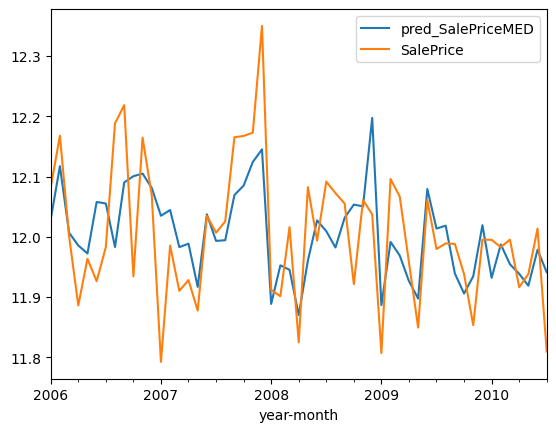

In [20]:
y_avg_df = pd.DataFrame(y_avg).reset_index()
y_avg_df['pred_SalePriceMED'] = y_pred_avg
y_avg_df['Year'] = None
y_avg_df['Month']= None
y_avg_df[['Year','Month']] =pd.DataFrame(y_avg_df['join_id'].str.split('_').tolist(), columns = ['Year','Month']).astype(int)
y_avg_df['year-month'] = pd.to_datetime(y_avg_df['Year'].astype(str)  +'-'+ y_avg_df['Month'].astype(str), format='%Y-%m')
y_avg_df = y_avg_df.sort_values(by = 'year-month')
y_avg_df[['year-month','pred_SalePriceMED','SalePrice']].set_index('year-month').plot();

## Lets include this score as a feature

In [21]:
xs_ext = xs_ext.iloc[:,:-11]
xs_ext['join_id'] = xs_ext['YrSold'].astype(int).astype(str) + '_' + xs_ext['MoSold'].astype(int).astype(str)
xs_ext = xs_ext.merge(y_avg_df[['join_id','pred_SalePriceMED']], on = ['join_id']).drop(['join_id'],axis = 1)

valid_xs_ext = valid_xs_ext.iloc[:,:-11]
valid_xs_ext['join_id'] = valid_xs_ext['YrSold'].astype(int).astype(str) + '_' + valid_xs_ext['MoSold'].astype(int).astype(str)
valid_xs_ext = valid_xs_ext.merge(y_avg_df[['join_id','pred_SalePriceMED']], on = ['join_id']).drop(['join_id'],axis = 1)

full_xs_ext = full_xs_ext.iloc[:,:-11]
full_xs_ext['join_id'] = full_xs_ext['YrSold'].astype(int).astype(str) + '_' + full_xs_ext['MoSold'].astype(int).astype(str)
full_xs_ext = full_xs_ext.merge(y_avg_df[['join_id','pred_SalePriceMED']], on = ['join_id']).drop(['join_id'],axis = 1)

<ipython-input-21-2e92af63373a>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [22]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV


# Define the model
model = ElasticNet()

# Hyperparameter grid to search 
param_grid = {
    'alpha': [0.001,0.002,.003,.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,100],
    'l1_ratio': [0.001,0.002,.003,.005,0.01,0.02,0.05,0.1,0.2,0.5,0.9,0.99]
} 

# Create a GridSearchCV 
grid_search = GridSearchCV(estimator=model, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring='neg_root_mean_squared_error') 

# Fit the grid search to the training data
grid_search.fit(xs_ext, y_ext) 

# Get the best parameters 
best_params_en = grid_search.best_params_ 
print("Best parameters:", best_params_en) 

# Create a new model with the best parameters 
best_model = ElasticNet(**best_params_en) 
best_model.fit(xs_ext, y_ext) 

# Make predictions on the test set
test_score = best_model.score(valid_xs_ext, valid_y_ext)
y_pred_lr_ext = best_model.predict(valid_xs_ext) 

# Evaluate the model (RMSE)
print("RMSE on test set:", math.sqrt(mean_squared_error(valid_y_ext, y_pred_lr_ext)))
print("Test R^2 Score:", test_score)


final_model_elasticnet_ext = ElasticNet(**best_params_en)
final_model_elasticnet_ext.fit(full_xs_ext,full_y_ext)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.263e-01, tolerance: 1.436e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.517e-02, tolerance: 1.440e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.987e-01, tolerance: 1.436e-02
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

Best parameters: {'alpha': 0.02, 'l1_ratio': 0.003}
RMSE on test set: 0.154457261539814
Test R^2 Score: 0.8725900256360422


ElasticNet(alpha=0.02, l1_ratio=0.003)

In [23]:
# Hyperparameter optimization of RandomForestRegressor

# Define the objective function for Optuna
def objective_ext(trial):
    # Define the hyperparameter search space
    #n_estimators = trial.suggest_int("n_estimators", 1, 200)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    #max_features = trial.suggest_categorical("max_features", [1])

    # Create and evaluate the model
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
    model.fit(xs_ext, y_ext)
    score = m_rmse(model, valid_xs_ext, valid_y_ext)
    # return np.mean(score)  # Optuna minimizes, so negative MSE
    return score

# Run the optimization
# sampler=optuna.samplers.GPSampler()
study = optuna.create_study(direction="minimize")
study.optimize(objective_ext, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters found:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(xs_ext, y_ext)

# Evaluate on test set
test_score = final_model.score(valid_xs_ext, valid_y_ext)
rmse_result = m_rmse(final_model, valid_xs_ext, valid_y_ext)
print("Test RMSE Score:", rmse_result)
print("Test R^2 Score:", test_score)

final_model_rf_ext = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model_rf_ext.fit(full_xs_ext,full_y_ext)

[I 2025-03-13 06:45:21,127] A new study created in memory with name: no-name-a96d86f8-629a-4f5a-9b13-8c907b10a751
[I 2025-03-13 06:45:22,498] Trial 0 finished with value: 0.159903 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.159903.
[I 2025-03-13 06:45:24,211] Trial 1 finished with value: 0.149916 and parameters: {'max_depth': 22, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.149916.
[I 2025-03-13 06:45:26,224] Trial 2 finished with value: 0.149251 and parameters: {'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.149251.
[I 2025-03-13 06:45:27,673] Trial 3 finished with value: 0.159903 and parameters: {'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.149251.
[I 2025-03-13 06:45:29,061] Trial 4 finished with value: 0.159982 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf'

Best parameters found: {'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1}
Test RMSE Score: 0.145508
Test R^2 Score: 0.8869268661935458


RandomForestRegressor(max_depth=26, n_jobs=-1, random_state=42)

In [24]:
dft = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
dft_ids = dft[['Id']]
dft['YrSold'] = dft['YrSold'].astype(int)
dft['MoSold'] = dft['MoSold'].astype(int)
dft['join_id'] = dft['YrSold'].astype(str) + '_' + df['MoSold'].astype(str)
dft = dft.merge(external_data, on = ['join_id']).drop(columns = ['join_id','Year','Month','Id'], axis =1)
to_tst_ext = to_ext.new(dft)
to_tst_ext.process()

/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/usr/local/lib/python3.10/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

In [25]:

tst_xs = to_tst_ext.xs
tst_xs = tst_xs.iloc[:,:-11]
tst_xs['join_id'] = tst_xs['YrSold'].astype(int).astype(str) + '_' + tst_xs['MoSold'].astype(int).astype(str)
tst_xs = tst_xs.merge(y_avg_df[['join_id','pred_SalePriceMED']], on = ['join_id']).drop(['join_id'],axis = 1)

preds_rf_ext = np.exp(final_model_rf_ext.predict(tst_xs))
dfpreds_rf_ext = pd.DataFrame(preds_rf_ext)

preds_en_ext = np.exp(final_model_elasticnet_ext.predict(tst_xs))
dfpreds_en_ext = pd.DataFrame(preds_en_ext)

df_submit_rf_ext = dft_ids.merge(dfpreds_rf_ext,left_index=True,right_index=True)
df_submit_rf_ext = df_submit_rf_ext.rename(columns = {0:'SalePrice'})

df_submit_en_ext = dft_ids.merge(dfpreds_en_ext,left_index=True,right_index=True)
df_submit_en_ext = df_submit_en_ext.rename(columns = {0:'SalePrice'})

df_submit_rf_ext.to_csv('/kaggle/working/submission3ext_rf.csv',index = False)
df_submit_en_ext.to_csv('/kaggle/working/submission3ext_en.csv',index = False)

## Scores with External Data
- No improvement, worse results actually